# ANAC

# data read-in

In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score

from scipy.stats import skew, kurtosis, probplot

In [174]:
seed = 2024
np.random.seed(seed)

In [175]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

/var/folders/z0/24mzs0z565s6qpzztgbdrj780000gn/T/ipykernel_98670/3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


# Basics: Rename columns and change dtypes

In [176]:
diet_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
reviews_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)

diet_csv["Diet"] = diet_csv["Diet"].astype("category")
recipes_csv["RecipeCategory"] = recipes_csv["RecipeCategory"].astype("category")

requests_csv.rename(columns= {
    "AuthorId" : "CustomerId",
    "Time": "MaxTime"
}, inplace=True)

# Handing missing values and change dtypes

In [177]:
diet_csv = diet_csv.dropna(subset=['Diet'])

# with mean
recipesServings_mean = recipes_csv['RecipeServings'].mean()
#fill na rows with the mean
recipes_csv['RecipeServings'].fillna(recipesServings_mean, inplace=True)


mapping_cal = {1: 'Yes', 0.0: 'No'}
requests_csv['HighCalories'] = requests_csv['HighCalories'].map(mapping_cal).astype('category')

mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No' }
requests_csv['HighProtein'] = requests_csv['HighProtein'].map(mapping_protein).astype('category')

mapping_cal = {1: 'Yes', 0.0: 'No'}
requests_csv['LowFat'] = requests_csv['LowFat'].map(mapping_cal).astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No' }
requests_csv['LowSugar'] = requests_csv['LowSugar'].map(mapping_sugar).astype('category')

mapping_cal = {1: 'Yes', 0.0: 'No'}
requests_csv['HighFiber'] = requests_csv['HighFiber'].map(mapping_cal).astype('category')


/var/folders/z0/24mzs0z565s6qpzztgbdrj780000gn/T/ipykernel_98670/3096394067.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  recipes_csv['RecipeServings'].fillna(recipesServings_mean, inplace=True)


# Merge tables


In [178]:
#merge diet + review
reviews_csv["Like"] = reviews_csv["Like"].astype("category")
reviews_csv = reviews_csv.drop("Rating", axis=1)
reviews_csv.dropna(subset=["Like"], inplace=True) # note: now the entries are reduced to 97381 entries
reviews_csv = reviews_csv.drop("TestSetId", axis=1)
review_with_diet = pd.merge(reviews_csv, diet_csv, on="CustomerId", how="inner") # 97381 entries
#merge diet + review + request
review_diet_with_request = pd.merge(review_with_diet, requests_csv, on=["CustomerId", "RecipeId"], how="inner") # 97381 entries
df = pd.merge(review_diet_with_request, recipes_csv, on='RecipeId', how='left')

df = pd.get_dummies(df, columns=['Diet','RecipeCategory', 'HighCalories', 'LowFat', 'HighFiber', 'HighProtein', 'LowSugar'], drop_first=True)

df.rename(columns={
    'HighCalories_Yes': 'want_HighCalories',
    'LowFat_Yes':'want_LowFat',
    'HighFiber_Yes':'want_HighFiber',
    'HighProtein_Yes':'want_HighProtein',
}, inplace=True)

#have to handle outlier here
df = df[df["Calories"] < 300000]
df

,CustomerId,RecipeId,Like,Age,MaxTime,Name,CookTime,PrepTime,RecipeIngredientQuantities,RecipeIngredientParts,...,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,want_HighCalories,want_LowFat,want_HighFiber,want_HighProtein,LowSugar_No
0,1000036C,320576,False,50,119.024930,Downeaster,0,120,"""2""","c(""\""vodka\"""", ""\""cranberry juice\"""", ""\""lime ...",...,False,False,False,False,False,False,False,True,False,False
1,1000216B,189335,False,78,1199.386790,Thai Rice Soup (Kao Tome Gai),600,600,"c(""\""6\"""", ""\""4\"""", ""\""8\"""", ""\""4\"""", ""\""1/2\""...","c(""\""garlic\"""", ""\""cooked rice\"""", ""\""ground c...",...,False,False,False,True,False,False,False,True,True,True
2,1000221A,133043,False,25,362.152341,Lemon and Thyme Marinade for Poultry,60,300,"c(""\""4\"""", ""\""4\"""", ""\""4\"""")","c(""\""lemon juice\"""", ""\""fresh thyme\"""", ""\""dri...",...,False,False,False,True,False,False,False,True,True,False
3,1000221A,90537,False,25,1198.957497,Black Bean Salsa,0,1200,"c(""\""2\"""", ""\""1\"""", ""\""1/2\"""", ""\""1\"""", ""\""1\""...","c(""\""black beans\"""", ""\""frozen corn\"""", ""\""gre...",...,True,False,False,False,False,False,False,True,True,True
4,1000221A,334314,False,25,5400.036634,Irish Soda Bread,3600,1800,"c(""\""3\"""", ""\""2/3\"""", ""\""3\"""", ""\""1\"""", ""\""1/2...","c(""\""flour\"""", ""\""sugar\"""", ""\""baking powder\""...",...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97376,999595E,338070,False,31,3899.421310,Pumpkin Cake Mix Dessert,3000,900,"c(""\""1\"""", ""\""1\"""", ""\""1\"""", ""\""3\"""", ""\""1\"""",...","c(""\""pumpkin puree\"""", ""\""evaporated milk\"""", ...",...,False,False,False,True,False,False,True,False,False,False
97377,999774A,29002,False,57,2402.372535,Summer Corkscrew Pasta,1200,1200,"c(""\""1\"""", ""\""8 -10\"""", ""\""3\"""", ""\""1/3\"""", ""\...","c(""\""corkscrew macaroni\"""", ""\""zucchini\"""", ""\...",...,False,False,False,True,False,False,False,False,False,False
97378,999774A,159252,False,57,5999.598903,"Chili, Kaffir Lime and Lemongrass Jelly",4800,1200,"c(""\""12\"""", ""\""5\"""", ""\""2\"""", ""\""2\"""", ""\""4\"""")","c(""\""kaffir lime leaves\"""", ""\""apples\"""", ""\""l...",...,False,False,False,True,False,False,False,False,True,True
97379,999774A,1171,True,57,480.233207,Kahlua Hot Chocolate,360,120,"c(""\""2\"""", ""\""1/4\"""", ""\""2\"""", ""\""1/4\"""", ""\""2...","c(""\""sugar\"""", ""\""ground cinnamon\"""", ""\""groun...",...,False,False,False,False,False,True,False,False,True,True


In [179]:
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace(")", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("(", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("\"", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("\\", '')
df['RecipeIngredientParts'] = df['RecipeIngredientParts'].str.replace('^c', '', regex=True)

In [180]:
df['RecipeIngredientParts']

0                       vodka, cranberry juice, lime wedge
1        garlic, cooked rice, ground chicken, ground tu...
2         lemon juice, fresh thyme, dried thyme, olive oil
3        black beans, frozen corn, green pepper, tomato...
4        flour, sugar, baking powder, baking soda, salt...
                               ...                        
97376    pumpkin puree, evaporated milk, sugar, eggs, c...
97377    corkscrew macaroni, zucchini, garlic cloves, p...
97378    kaffir lime leaves, apples, lemongrass, red ch...
97379    sugar, ground cinnamon, ground nutmeg, milk, K...
97380    cornmeal, butter, boiling water, eggs, milk, b...
Name: RecipeIngredientParts, Length: 97380, dtype: object

In [181]:
def check_keywords(ingredients):
    has_animal_product = any(any(keyword in ingredient.lower() for keyword in ["meat", "chicken", "lamb", "beef", "pork", "bacon", "fish", "sausage", "turkey", "milk", "butter", "egg", "cheese", "breast", "gelatin", "honey", "tuna", "steak", "salmon", "shrimps"]) for ingredient in ingredients)
    has_fish_or_meat = any(any(keyword in ingredient.lower() for keyword in ["meat", "chicken", "lamb", "beef", "pork", "bacon", "fish", "sausage", "turkey", "tuna", "steak", "salmon", 'shrimps']) for ingredient in ingredients)
    return has_animal_product, has_fish_or_meat

df[['has_animal_product', 'has_fish_meat']] = df['RecipeIngredientParts'].str.split(',').apply(check_keywords).apply(pd.Series)


In [182]:
df[['Like', 'Diet_Vegan', 'Diet_Vegetarian', 'RecipeIngredientParts', 'has_animal_product', 'has_fish_meat']]

,Like,Diet_Vegan,Diet_Vegetarian,RecipeIngredientParts,has_animal_product,has_fish_meat
0,False,False,True,"vodka, cranberry juice, lime wedge",False,False
1,False,False,True,"garlic, cooked rice, ground chicken, ground tu...",True,True
2,False,False,True,"lemon juice, fresh thyme, dried thyme, olive oil",False,False
3,False,False,True,"black beans, frozen corn, green pepper, tomato...",False,False
4,False,False,True,"flour, sugar, baking powder, baking soda, salt...",True,False
...,...,...,...,...,...,...
97376,False,False,True,"pumpkin puree, evaporated milk, sugar, eggs, c...",True,False
97377,False,False,True,"corkscrew macaroni, zucchini, garlic cloves, p...",True,False
97378,False,False,True,"kaffir lime leaves, apples, lemongrass, red ch...",False,False
97379,True,False,True,"sugar, ground cinnamon, ground nutmeg, milk, K...",True,False


In [183]:
df['for_Vegan'] = ~df['has_animal_product'] & ~df['has_fish_meat']
df['for_Vegetarian'] = (df['has_animal_product'] & ~df['has_fish_meat']) | (~df['has_animal_product'] & ~df['has_fish_meat'])
df[['Like', 'Diet_Vegan', 'Diet_Vegetarian', 'RecipeIngredientParts', 'has_animal_product', 'has_fish_meat','for_Vegan', 'for_Vegetarian' ]]

,Like,Diet_Vegan,Diet_Vegetarian,RecipeIngredientParts,has_animal_product,has_fish_meat,for_Vegan,for_Vegetarian
0,False,False,True,"vodka, cranberry juice, lime wedge",False,False,True,True
1,False,False,True,"garlic, cooked rice, ground chicken, ground tu...",True,True,False,False
2,False,False,True,"lemon juice, fresh thyme, dried thyme, olive oil",False,False,True,True
3,False,False,True,"black beans, frozen corn, green pepper, tomato...",False,False,True,True
4,False,False,True,"flour, sugar, baking powder, baking soda, salt...",True,False,False,True
...,...,...,...,...,...,...,...,...
97376,False,False,True,"pumpkin puree, evaporated milk, sugar, eggs, c...",True,False,False,True
97377,False,False,True,"corkscrew macaroni, zucchini, garlic cloves, p...",True,False,False,True
97378,False,False,True,"kaffir lime leaves, apples, lemongrass, red ch...",False,False,True,True
97379,True,False,True,"sugar, ground cinnamon, ground nutmeg, milk, K...",True,False,False,True


In [184]:
df['Correct_Diet'] = (~df['Diet_Vegetarian'] & ~df['Diet_Vegan']) | (df['Diet_Vegan'] & df['for_Vegan']) | (df['Diet_Vegetarian']  & df['for_Vegetarian'] )
df[['Like', 'Diet_Vegan', 'Diet_Vegetarian', 'RecipeIngredientParts', 'has_animal_product', 'has_fish_meat','for_Vegan', 'for_Vegetarian', 'Correct_Diet']]

,Like,Diet_Vegan,Diet_Vegetarian,RecipeIngredientParts,has_animal_product,has_fish_meat,for_Vegan,for_Vegetarian,Correct_Diet
0,False,False,True,"vodka, cranberry juice, lime wedge",False,False,True,True,True
1,False,False,True,"garlic, cooked rice, ground chicken, ground tu...",True,True,False,False,False
2,False,False,True,"lemon juice, fresh thyme, dried thyme, olive oil",False,False,True,True,True
3,False,False,True,"black beans, frozen corn, green pepper, tomato...",False,False,True,True,True
4,False,False,True,"flour, sugar, baking powder, baking soda, salt...",True,False,False,True,True
...,...,...,...,...,...,...,...,...,...
97376,False,False,True,"pumpkin puree, evaporated milk, sugar, eggs, c...",True,False,False,True,True
97377,False,False,True,"corkscrew macaroni, zucchini, garlic cloves, p...",True,False,False,True,True
97378,False,False,True,"kaffir lime leaves, apples, lemongrass, red ch...",False,False,True,True,True
97379,True,False,True,"sugar, ground cinnamon, ground nutmeg, milk, K...",True,False,False,True,True


# Create new columns

In [185]:
df["DifferenceRequestedAndTimeNeeded"] = df["MaxTime"] - (df["CookTime"] + df["PrepTime"])

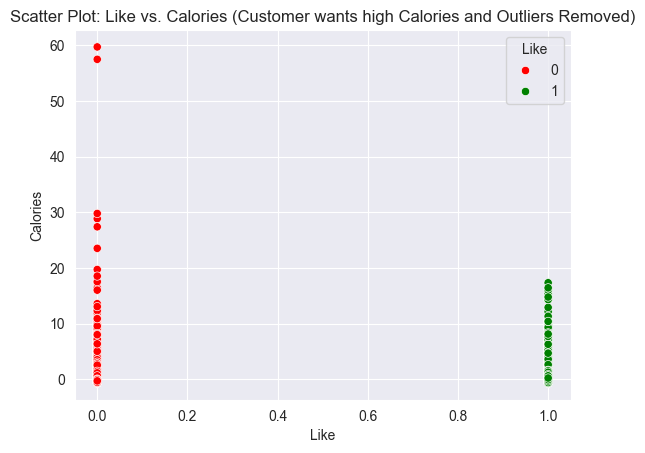

In [156]:
calories_threshold_df = df[["Like", "want_HighCalories", "Calories"]].copy()
calories_threshold_df = calories_threshold_df[calories_threshold_df['want_HighCalories'] == True]
calories_threshold_df['Like'] = calories_threshold_df['Like'].astype(int)
calories_threshold_df['want_HighCalories'] = calories_threshold_df['want_HighCalories'].astype(int)

sns.scatterplot(x='Like', y='Calories', hue='Like', data=calories_threshold_df, palette={0: 'red', 1: 'green'})
plt.xlabel('Like')
plt.ylabel('Calories')
plt.title('Scatter Plot: Like vs. Calories (Customer wants high Calories and Outliers Removed)')
plt.show()



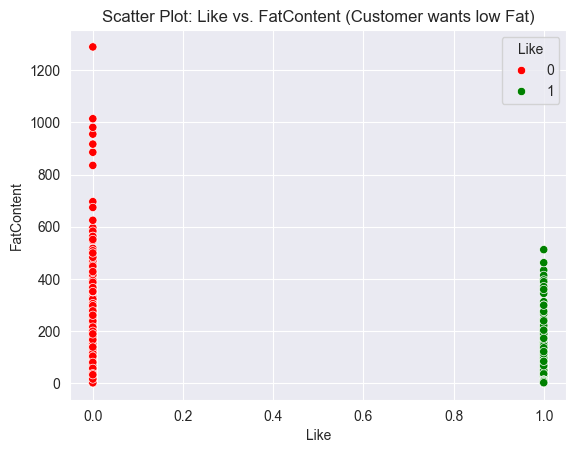

In [143]:
threshold_df = df[["Like", "want_LowFat", "FatContent"]].copy()
threshold_df = threshold_df[threshold_df['want_LowFat'] == True]

threshold_df['Like'] = threshold_df['Like'].astype(int)
threshold_df['want_LowFat'] = threshold_df['want_LowFat'].astype(int)

sns.scatterplot(x='Like', y='FatContent', hue='Like', data=threshold_df, palette={0: 'red', 1: 'green'})
plt.xlabel('Like')
plt.ylabel('FatContent')
plt.title('Scatter Plot: Like vs. FatContent (Customer wants low Fat)')
plt.show()


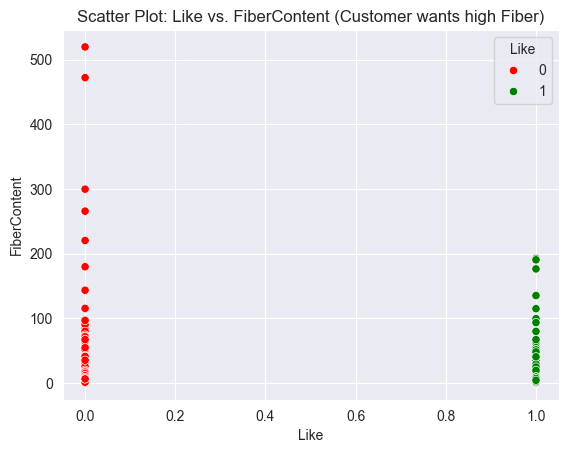

In [144]:
threshold_df = df[["Like", "want_HighFiber", "FiberContent"]].copy()
threshold_df = threshold_df[threshold_df['want_HighFiber'] == True]

threshold_df['Like'] = threshold_df['Like'].astype(int)
threshold_df['want_HighFiber'] = threshold_df['want_HighFiber'].astype(int)

sns.scatterplot(x='Like', y='FiberContent', hue='Like', data=threshold_df, palette={0: 'red', 1: 'green'})
plt.xlabel('Like')
plt.ylabel('FiberContent')
plt.title('Scatter Plot: Like vs. FiberContent (Customer wants high Fiber)')
plt.show()


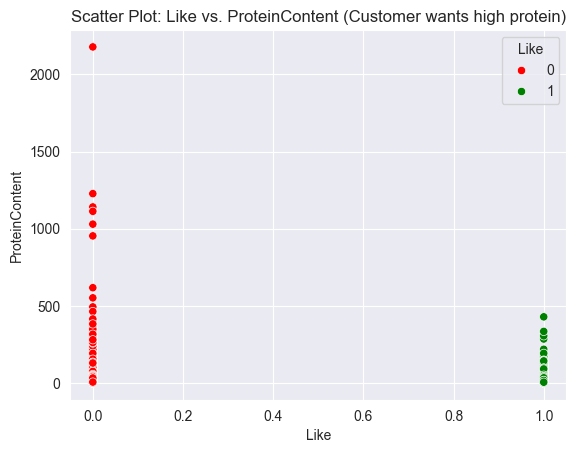

In [145]:

threshold_df = df[["Like", "want_HighProtein", "ProteinContent"]].copy()
threshold_df = threshold_df[threshold_df['want_HighProtein'] == False]

threshold_df['Like'] = threshold_df['Like'].astype(int)
threshold_df['want_HighProtein'] = threshold_df['want_HighProtein'].astype(int)

sns.scatterplot(x='Like', y='ProteinContent', hue='Like', data=threshold_df, palette={0: 'red', 1: 'green'})
plt.xlabel('Like')
plt.ylabel('ProteinContent')
plt.title('Scatter Plot: Like vs. ProteinContent (Customer wants high protein)')
plt.show()


# Check Feature Importance before Handling Outliers

## 1. Built-in feature importance

In [186]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, DMatrix

X = df.drop(['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product'], axis=1)
y = df['Like']

In [159]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)

# Ensure positive class weights
class_weights = np.abs(class_weights)

# Create a dictionary for class weights
class_weights_dict = {i: class_weights[i] for i in range(len(classes))}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.5761993798963339, 1: 3.780866594191645}


In [208]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

In [209]:
# have to pass them manually
class_weights_dict = {0: 0.5761993798963339, 1: 3.780866594191645}

# Manually create an array of sample weights for the training set
sample_weights_train = np.array([class_weights_dict[label] for label in y_train])
model = XGBRegressor(n_estimators=100, random_state=seed)
model.fit(X_train, y_train, sample_weight=sample_weights_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=2024, ...)

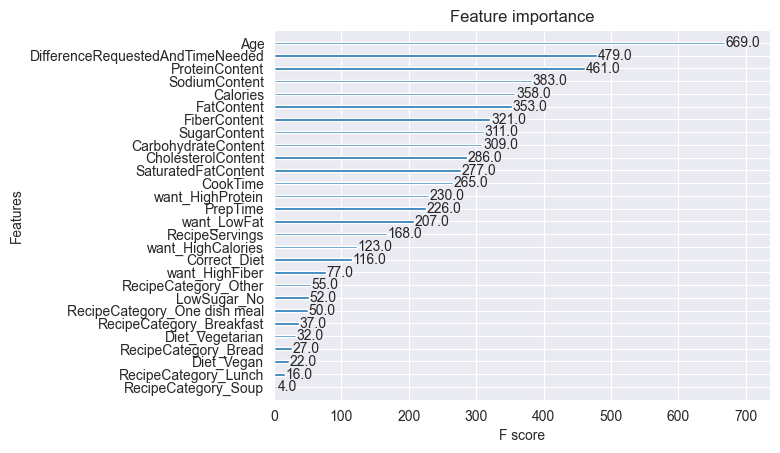

In [210]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(model)
plt.show()

## 2. Permutation Based Feature Importance

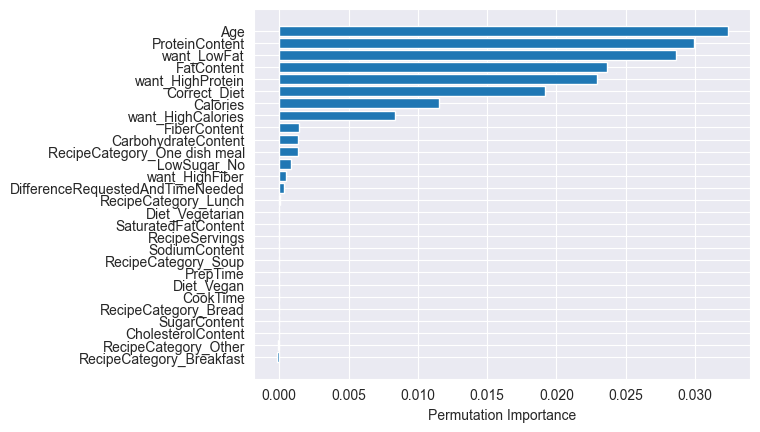

In [211]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [212]:
predictions = model.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, predictions)

print("Balanced Accuracy:", balanced_accuracy)

Balanced Accuracy: 0.686243132441745


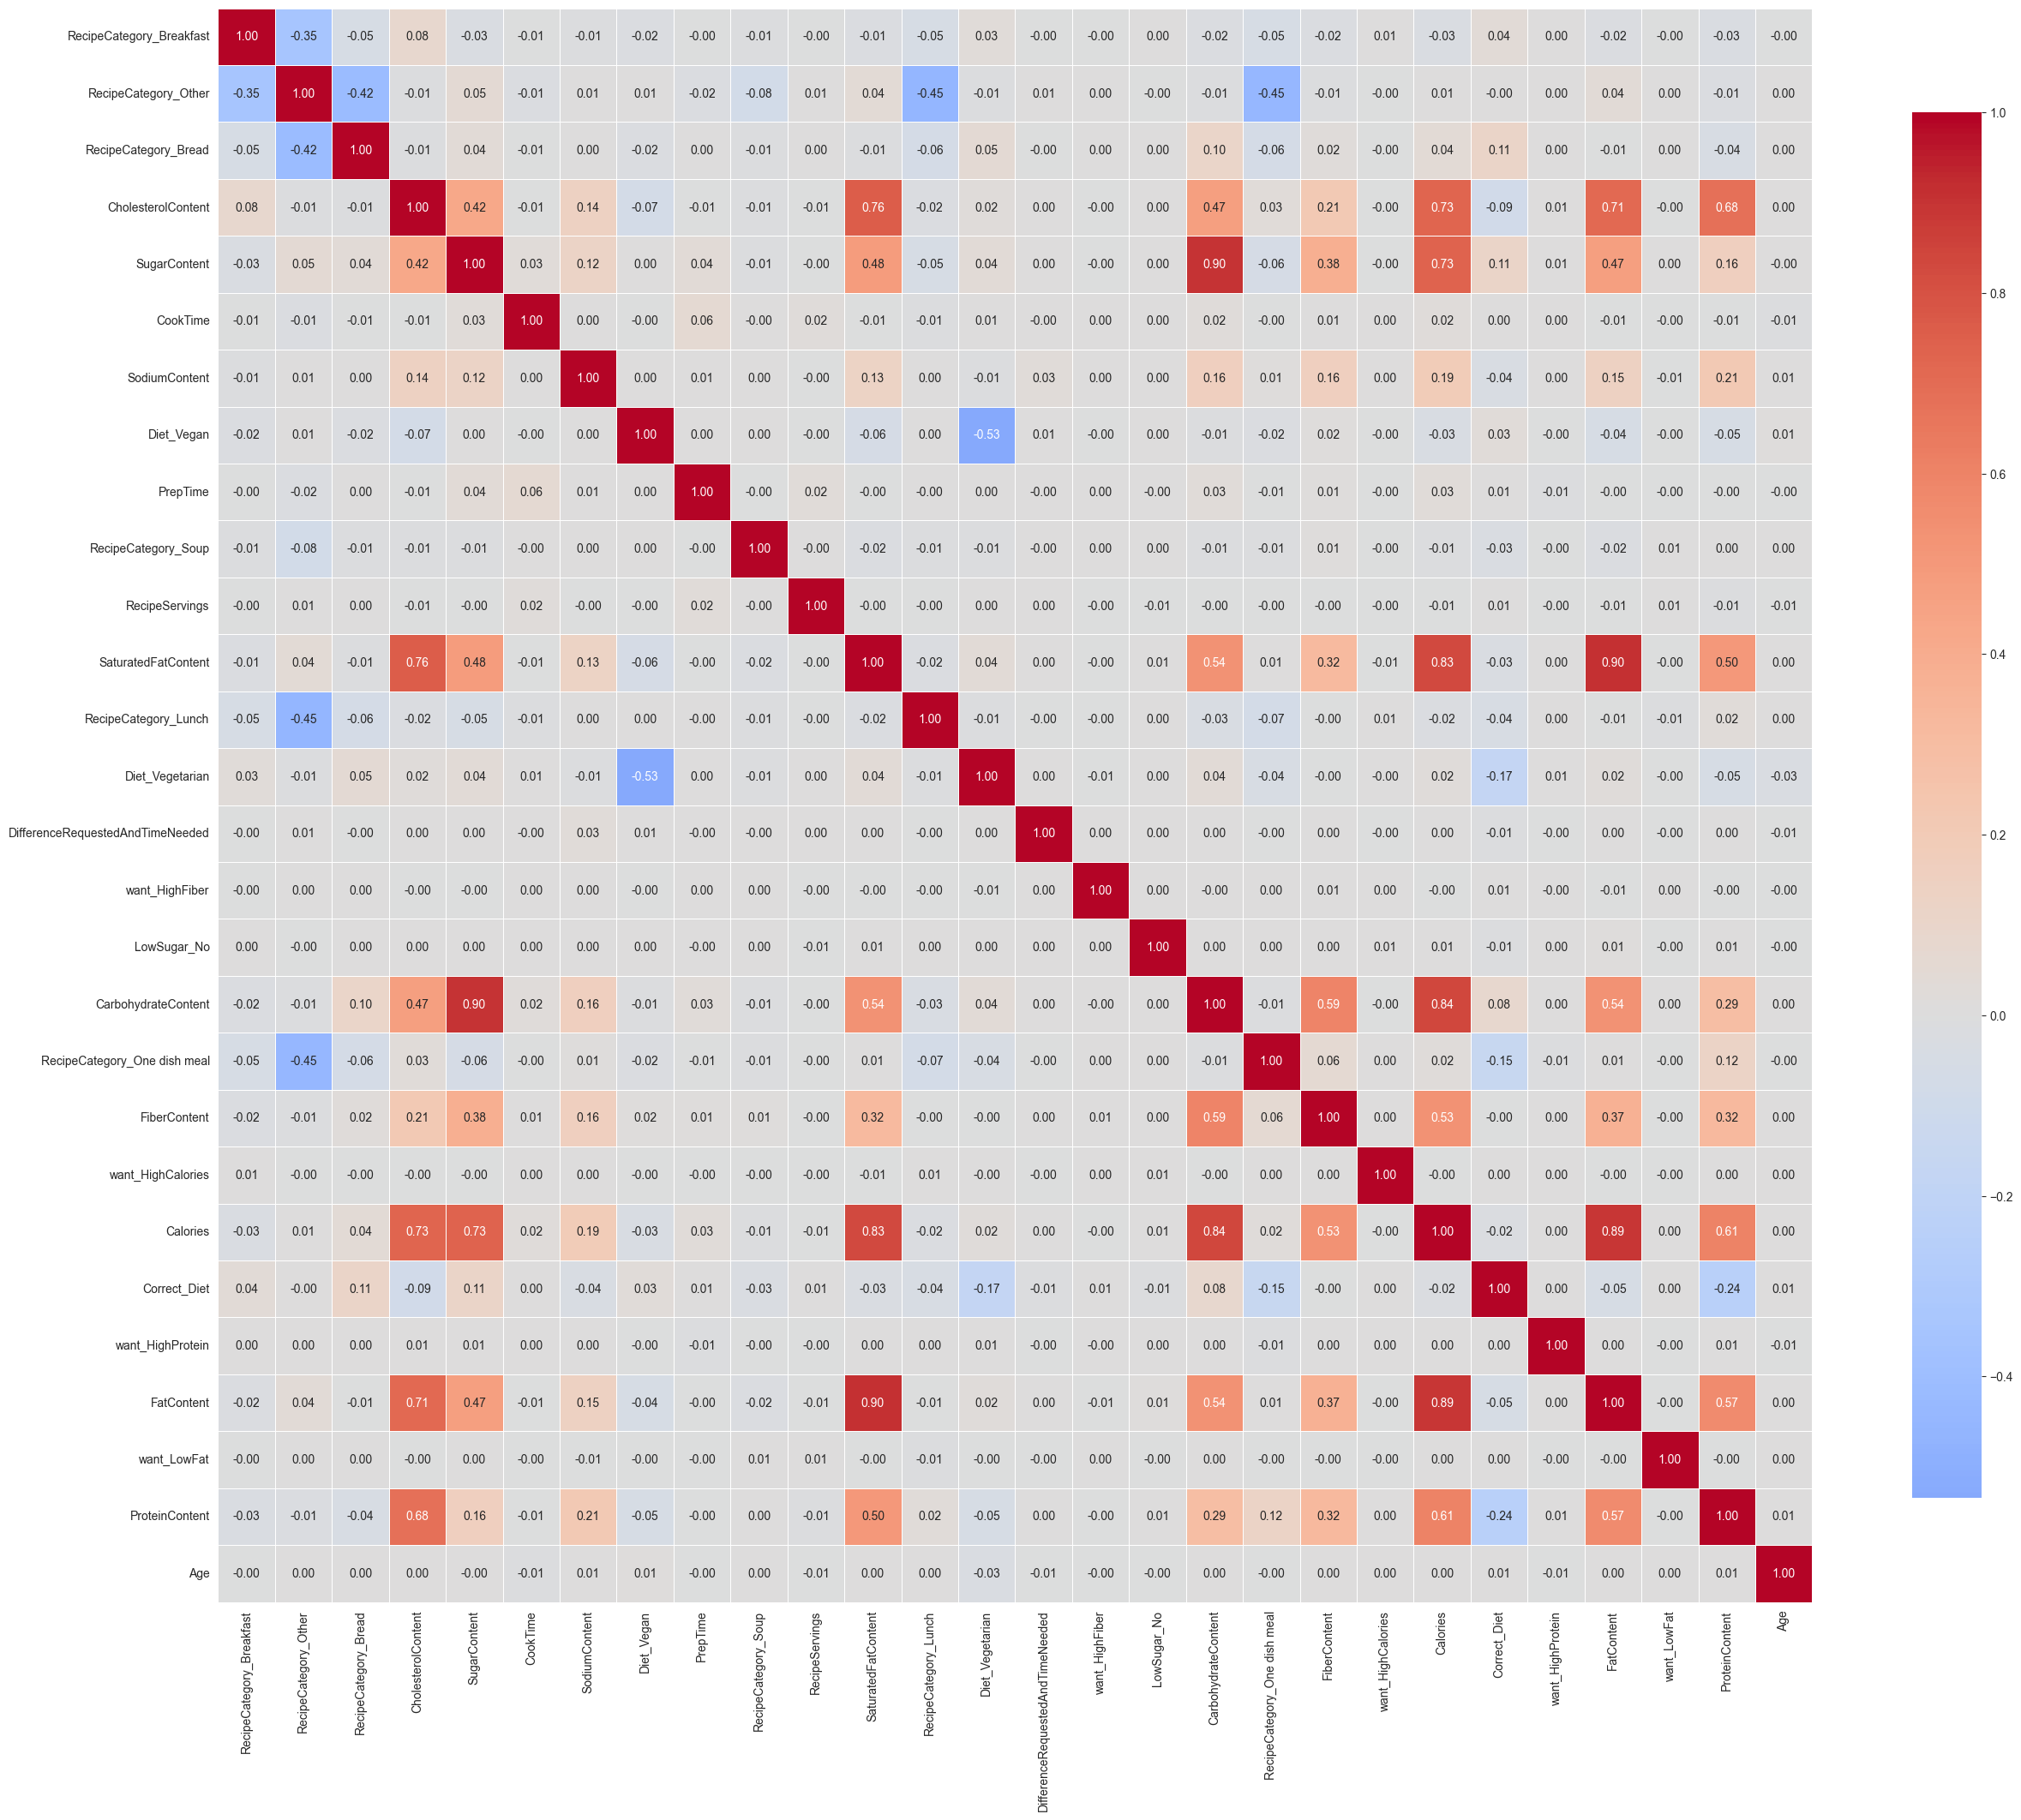

In [154]:
def correlation_heatmap(train):
    correlations = train.corr()
    
    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    
    plt.show();

correlation_heatmap(X_train[X.columns[sorted_idx]])

# Subsets - RecipeCategory

In [ ]:
soup_subset = df[df['RecipeCategory_Soup'] == True]


# Subsets - Diet

## vegan_subset

In [216]:
vegan_subset = df[df['Diet_Vegan'] == True]
vegetarian_subset = df[df['Diet_Vegetarian'] == True]
omnivore_subset = df[(df['Diet_Vegan'] == False) & (df['Diet_Vegetarian'] == False)]

In [217]:
X = vegan_subset.drop(['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product', ], axis=1)
y = vegan_subset['Like']

In [235]:
X

,Age,CookTime,PrepTime,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,...,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,want_HighCalories,want_LowFat,want_HighFiber,want_HighProtein,LowSugar_No,Correct_Diet,DifferenceRequestedAndTimeNeeded
10,22,3600,900,2060.1,16.4,3.4,6.3,9798.6,396.0,34.1,...,False,True,False,False,False,False,False,False,True,-0.197973
28,74,600,1800,705.5,49.7,20.9,159.2,651.0,22.4,1.0,...,False,False,False,False,True,False,True,True,True,0.657068
34,44,3600,1200,1689.4,157.3,62.3,335.1,375.6,32.2,5.5,...,False,True,False,False,False,False,False,False,True,1.368408
83,29,1200,0,549.7,21.9,3.4,77.4,131.2,43.4,1.9,...,False,True,False,False,False,True,False,True,True,0.231615
91,28,900,600,351.1,22.0,3.1,58.9,2089.2,12.2,0.6,...,False,True,False,False,False,False,False,True,True,-1.514242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97363,66,900,900,2361.9,224.6,30.9,84.4,2086.0,58.5,1.0,...,False,True,False,False,False,False,False,True,True,0.495340
97364,24,43200,600,85.2,6.4,4.0,19.8,145.4,2.0,0.8,...,False,True,False,True,False,True,True,False,True,0.056937
97371,60,1200,600,469.7,17.4,9.2,87.3,1272.0,49.3,3.6,...,True,False,False,False,False,False,False,False,True,-0.066706
97372,60,5400,1800,745.0,53.0,19.6,127.4,2365.5,40.1,7.6,...,False,True,False,False,False,False,False,True,True,0.236450


In [218]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

In [219]:
# have to pass them manually
class_weights_dict = {0: 0.5761993798963339, 1: 3.780866594191645}

# Manually create an array of sample weights for the training set
sample_weights_train = np.array([class_weights_dict[label] for label in y_train])
model = XGBRegressor(n_estimators=100, random_state=seed)
model.fit(X_train, y_train, sample_weight=sample_weights_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=2024, ...)

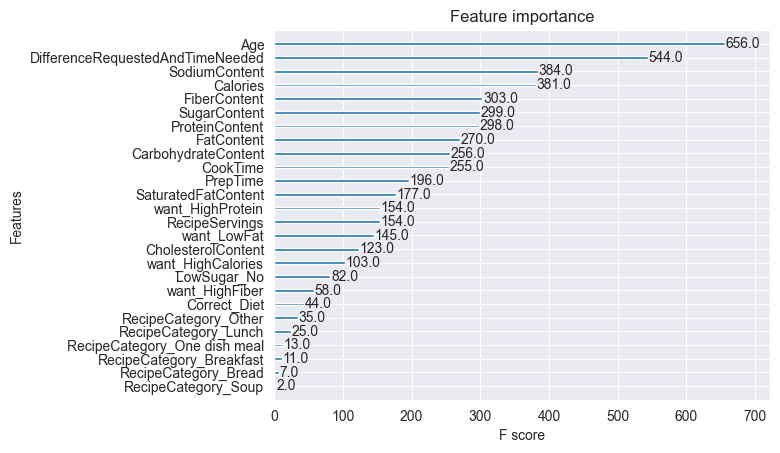

In [220]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(model)
plt.show()

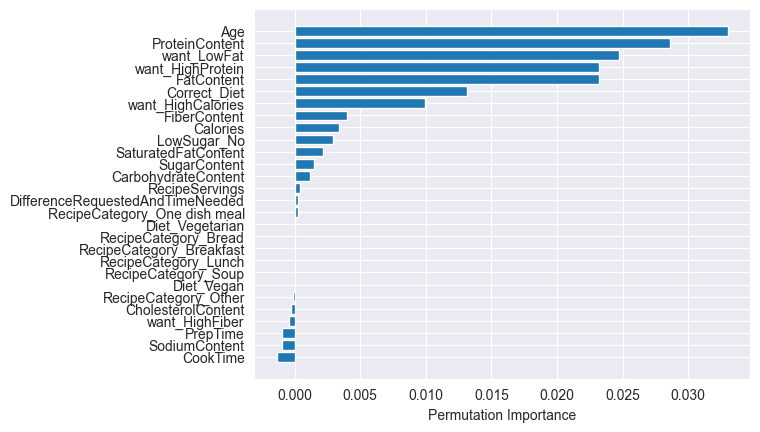

In [221]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [222]:
predictions = model.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, predictions)

print("Balanced Accuracy:", balanced_accuracy)

Balanced Accuracy: 0.6565775572052159


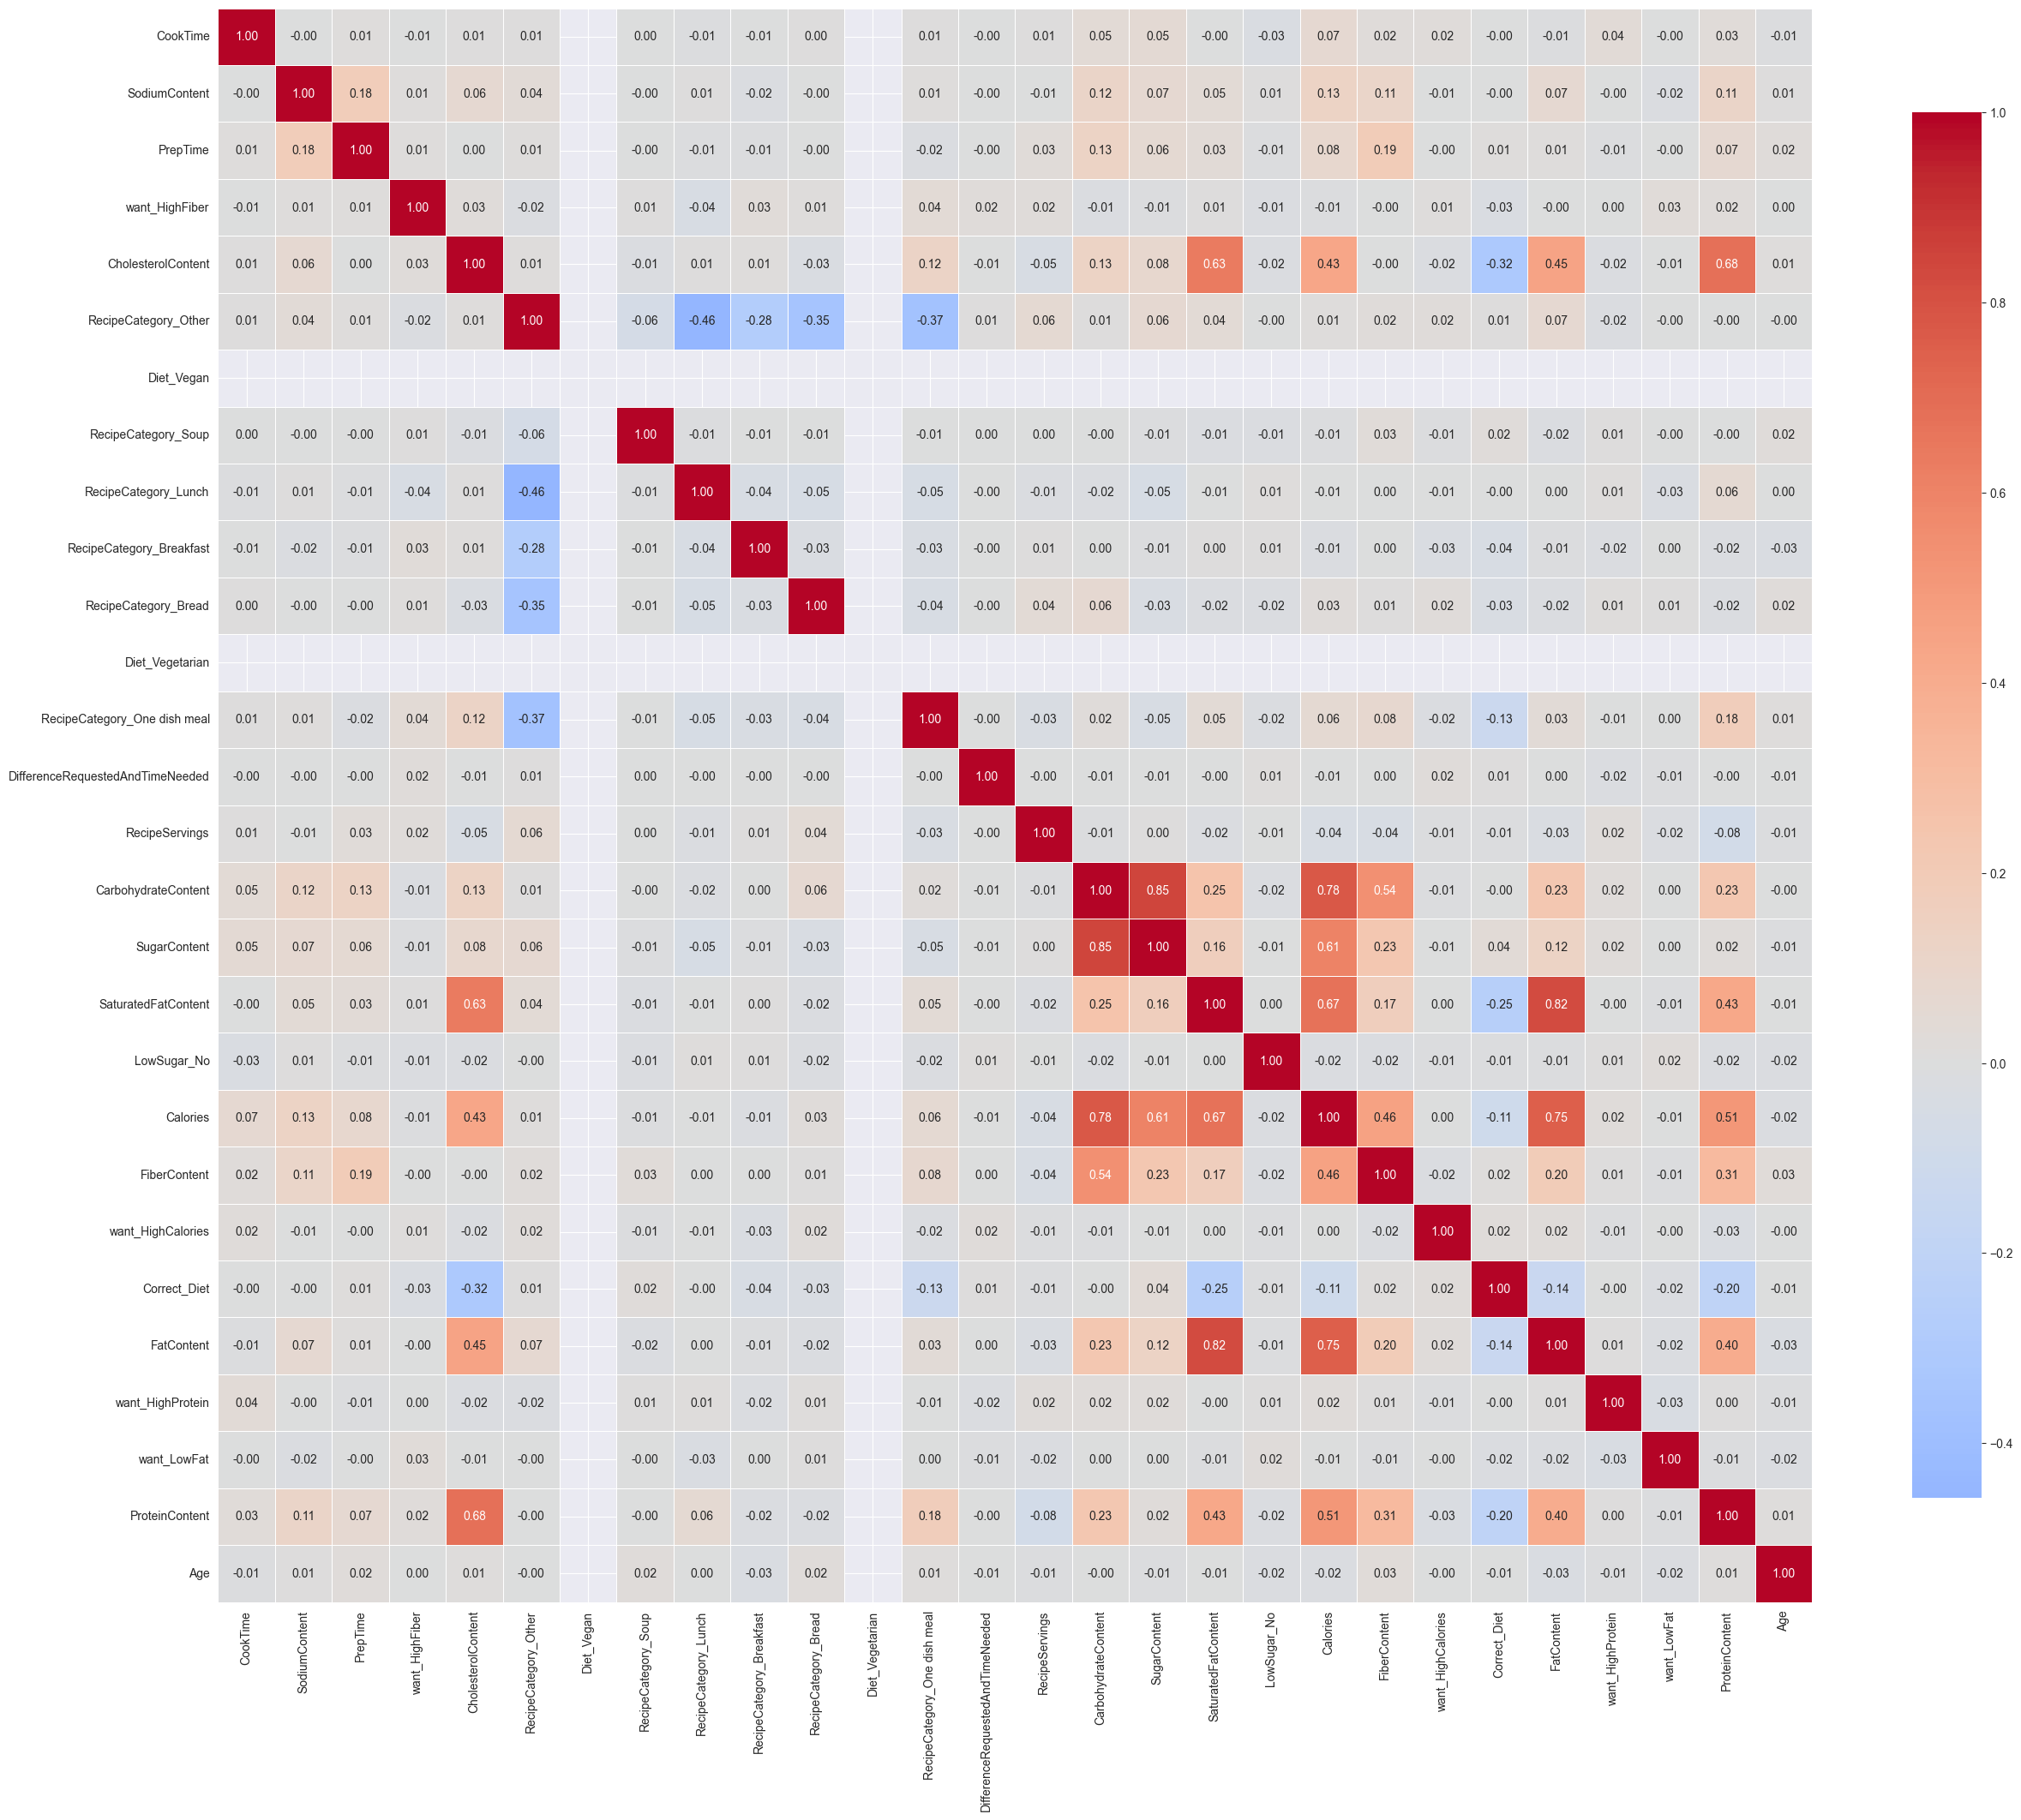

In [223]:
def correlation_heatmap(train):
    correlations = train.corr()
    
    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    
    plt.show();

correlation_heatmap(X_train[X.columns[sorted_idx]])

## vegetarian_subset

In [224]:
X = vegetarian_subset.drop(['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product'], axis=1)
y = vegetarian_subset['Like']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

# have to pass them manually
class_weights_dict = {0: 0.5761993798963339, 1: 3.780866594191645}

# Manually create an array of sample weights for the training set
sample_weights_train = np.array([class_weights_dict[label] for label in y_train])
model = XGBRegressor(n_estimators=100, random_state=seed)
model.fit(X_train, y_train, sample_weight=sample_weights_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=2024, ...)

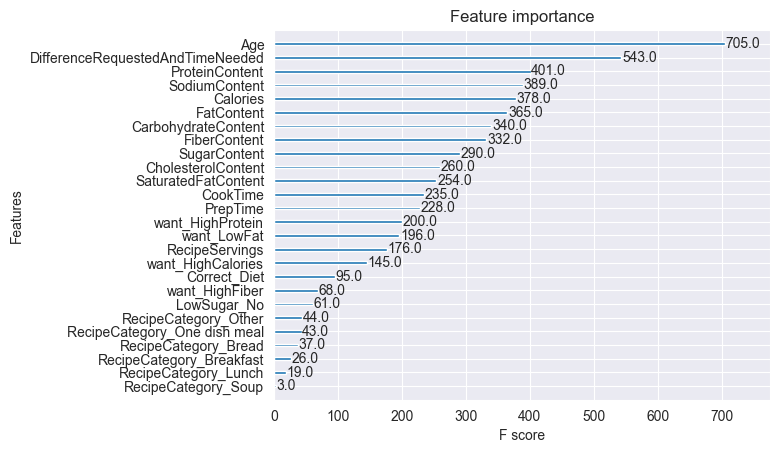

In [225]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(model)
plt.show()

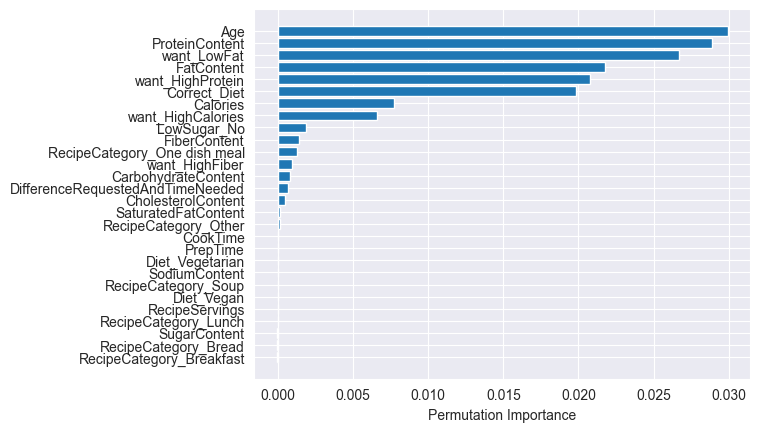

In [227]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [228]:
predictions = model.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, predictions)

print("Balanced Accuracy:", balanced_accuracy)

Balanced Accuracy: 0.680724556673894


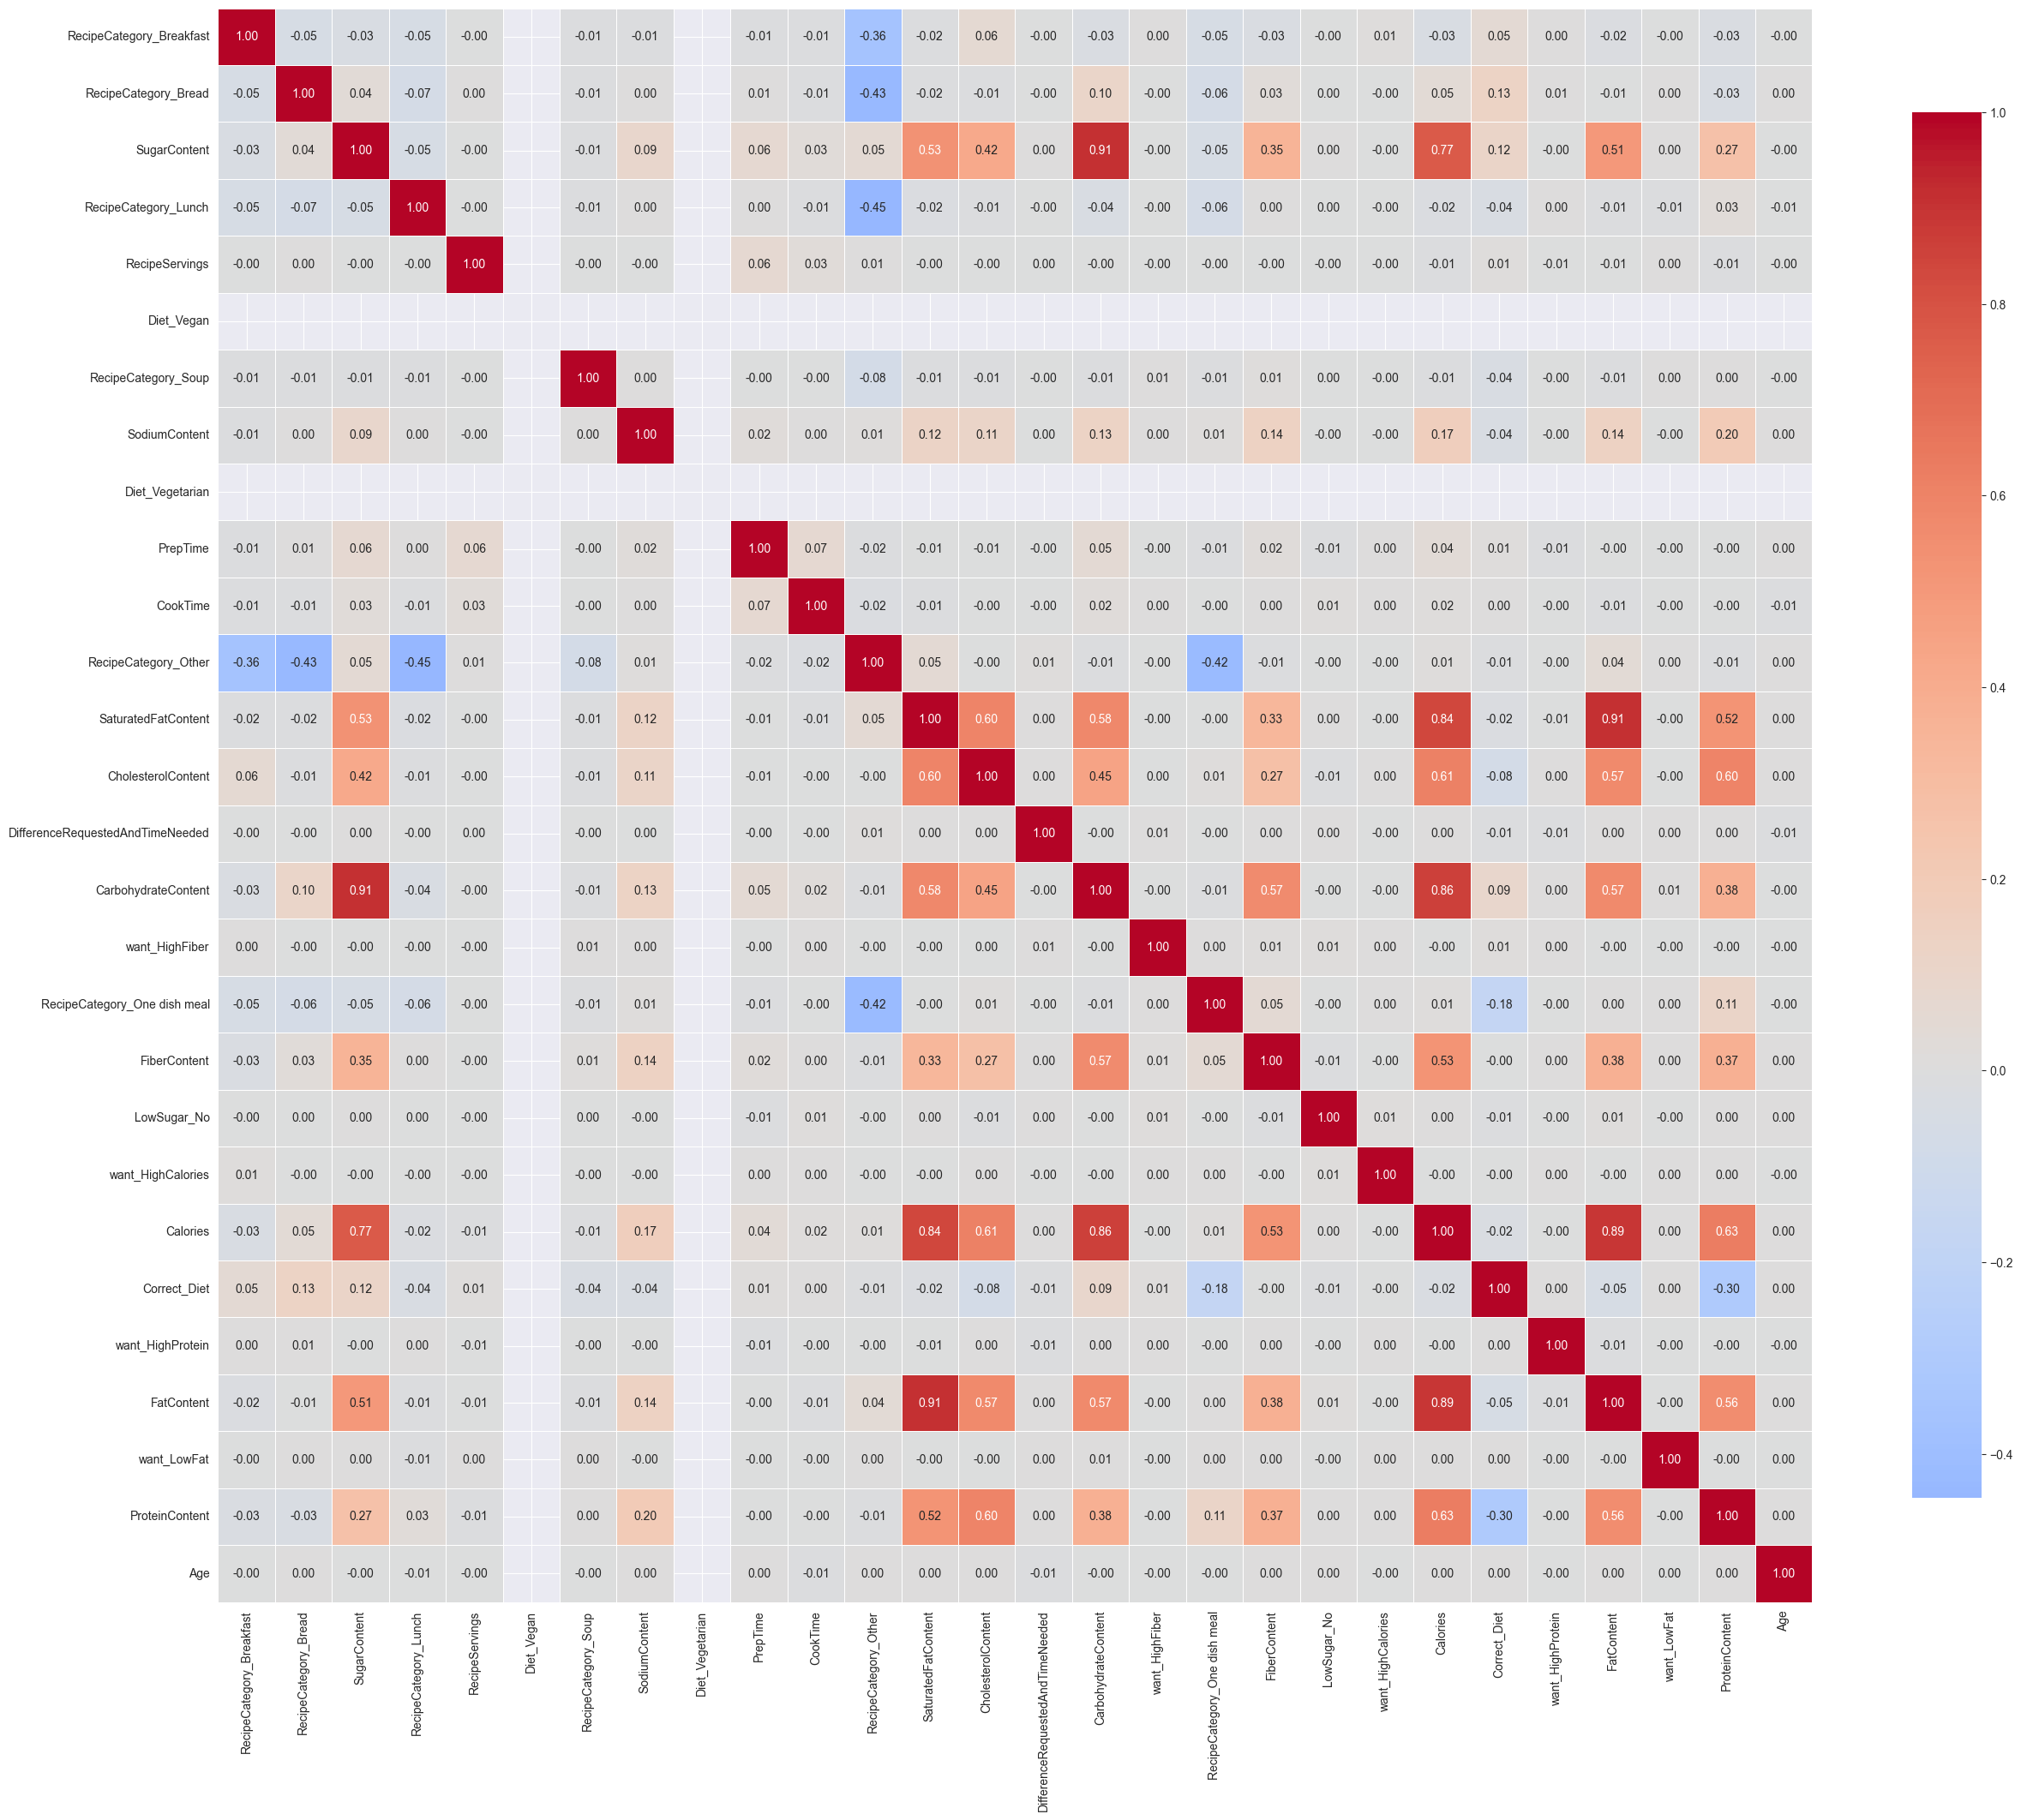

In [229]:
def correlation_heatmap(train):
    correlations = train.corr()
    
    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    
    plt.show();

correlation_heatmap(X_train[X.columns[sorted_idx]])

## omnivore_subset

In [230]:
X = omnivore_subset.drop(['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product'], axis=1)
y = omnivore_subset['Like']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

# have to pass them manually
class_weights_dict = {0: 0.5761993798963339, 1: 3.780866594191645}

# Manually create an array of sample weights for the training set
sample_weights_train = np.array([class_weights_dict[label] for label in y_train])
model = XGBRegressor(n_estimators=100, random_state=seed)
model.fit(X_train, y_train, sample_weight=sample_weights_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=2024, ...)

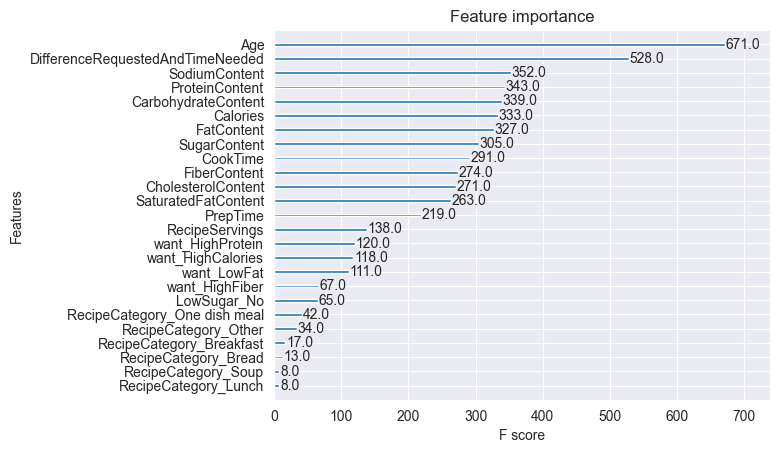

In [231]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(model)
plt.show()

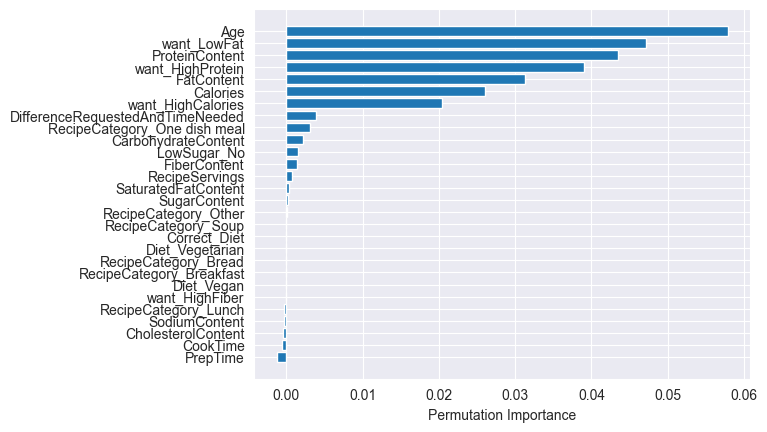

In [232]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [233]:
predictions = model.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, predictions)

print("Balanced Accuracy:", balanced_accuracy)

Balanced Accuracy: 0.7250115357147644


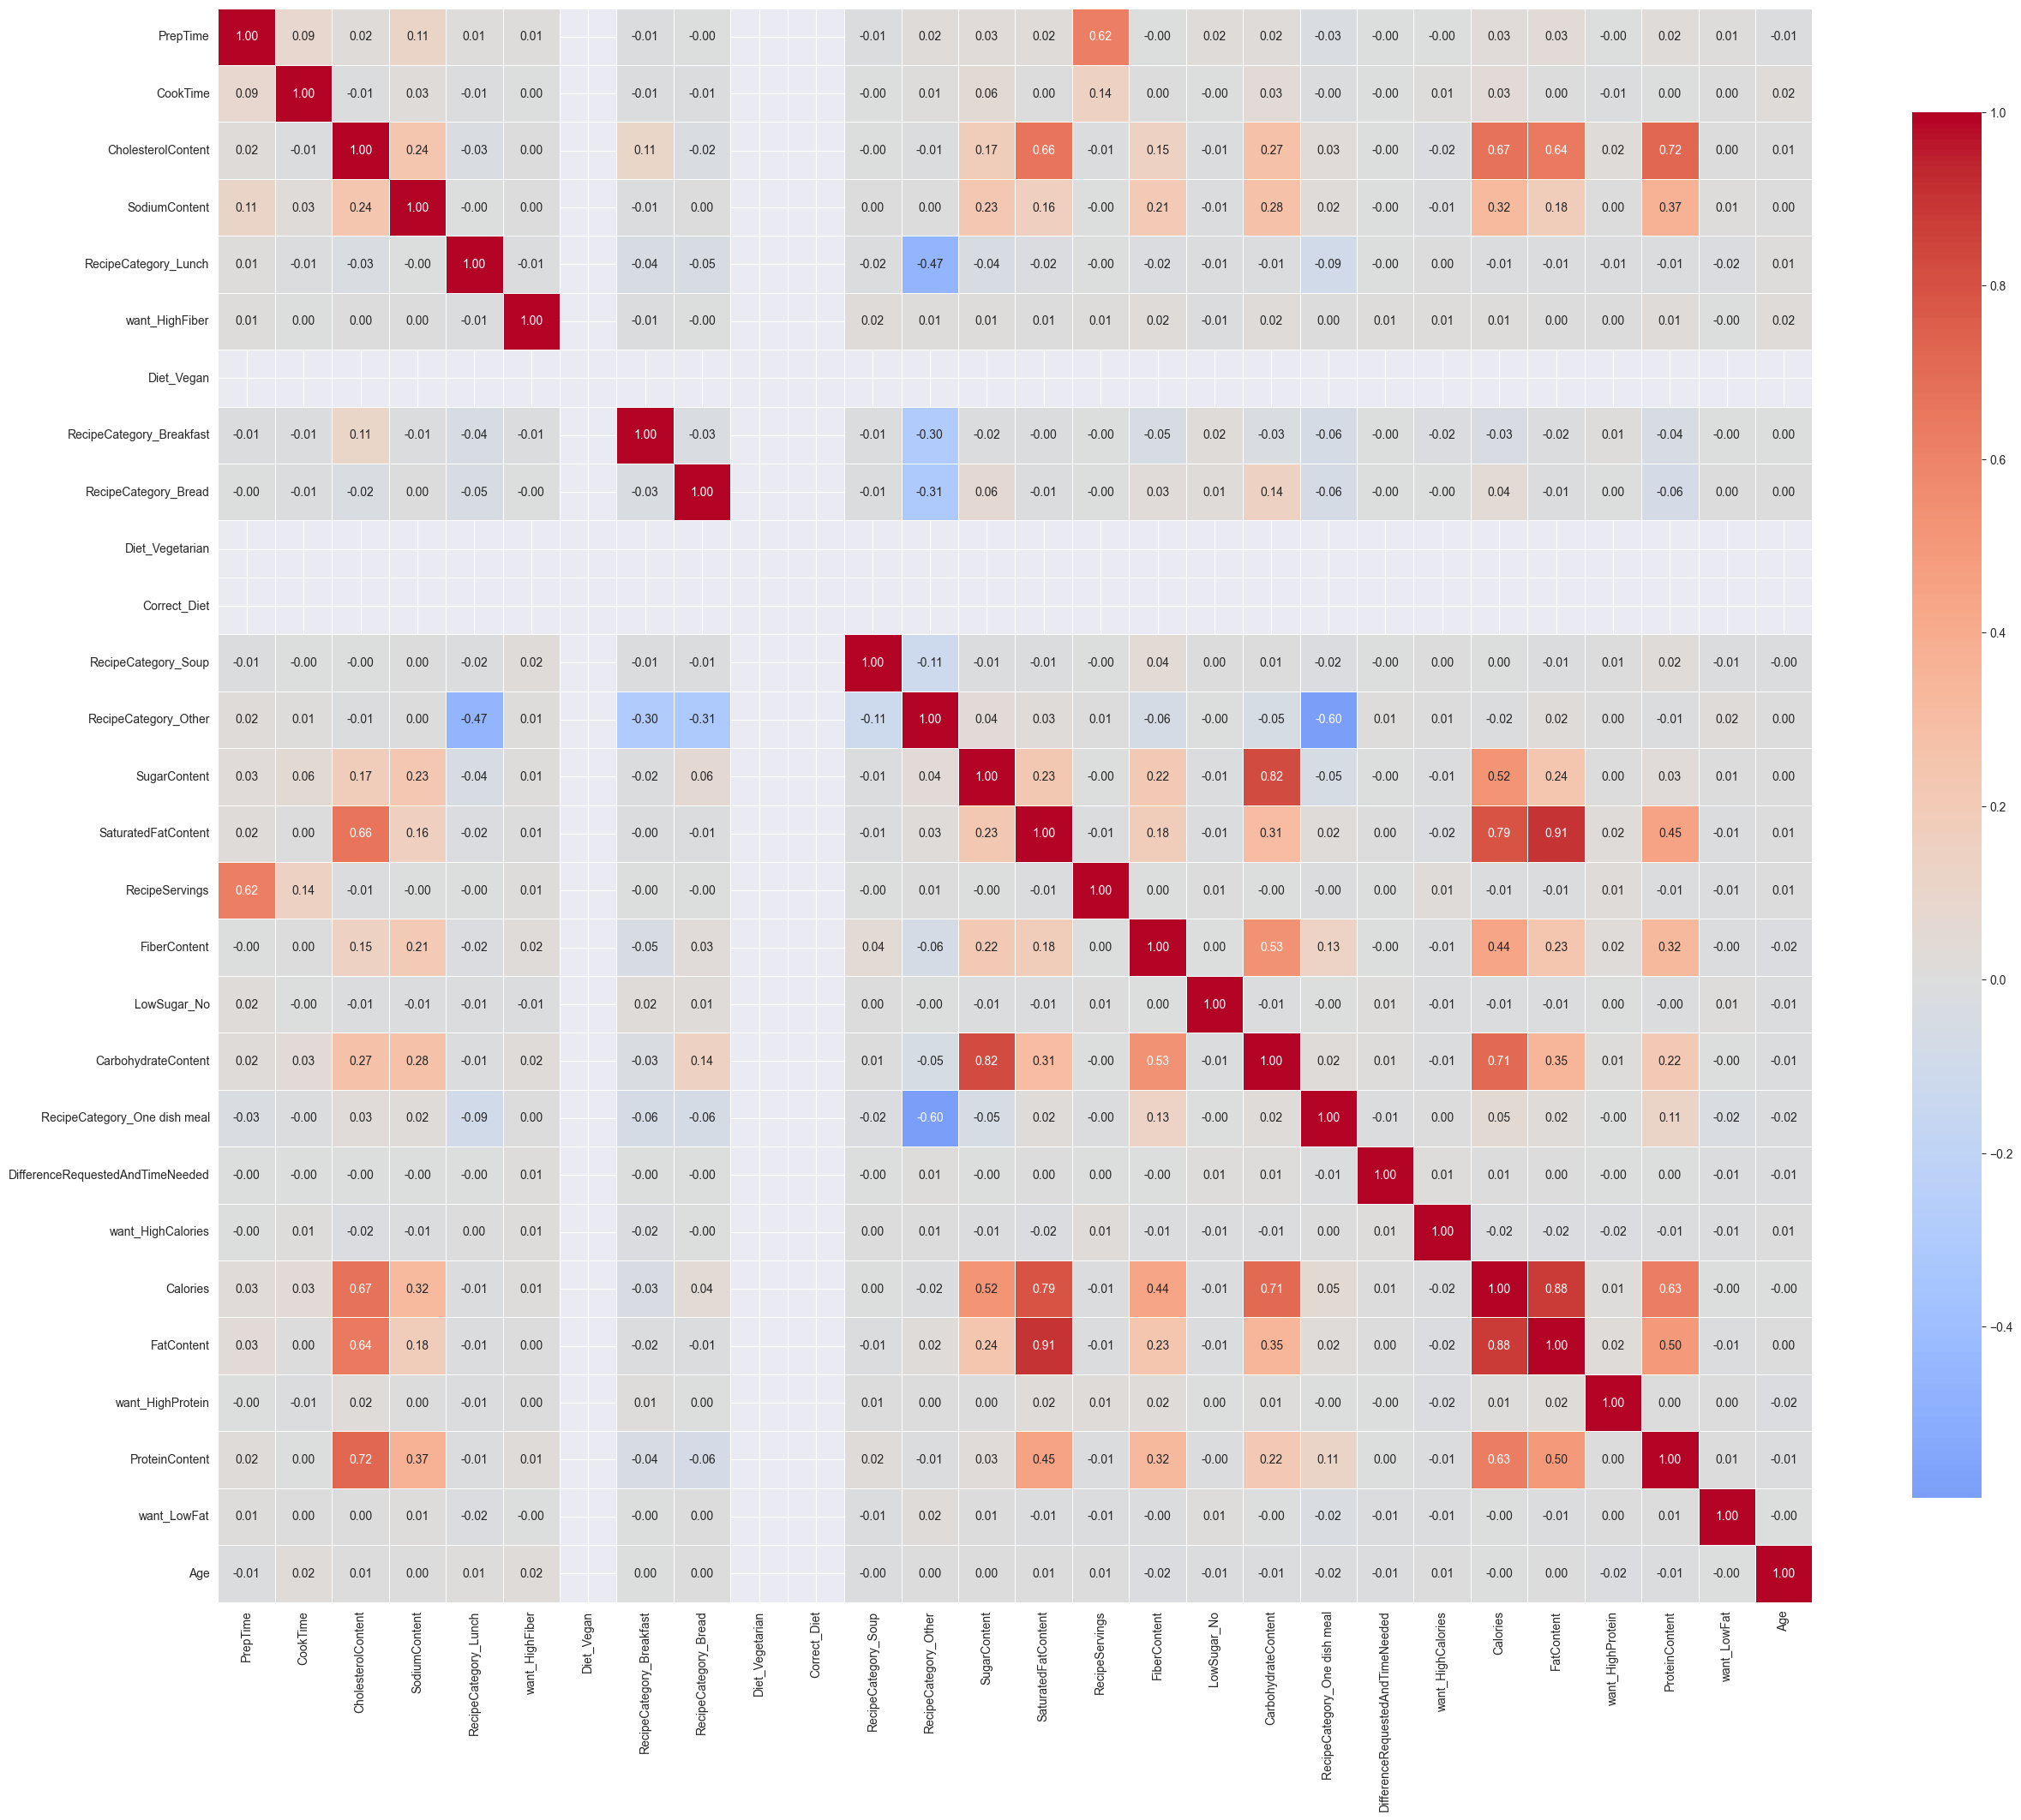

In [234]:
def correlation_heatmap(train):
    correlations = train.corr()
    
    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    
    plt.show();

correlation_heatmap(X_train[X.columns[sorted_idx]])

## Stop

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

columns_to_standardized= ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'MaxTime', 'PrepTime', 'CookTime', 'Age', 'RecipeServings']
#minmax_scaler = MinMaxScaler()
#df[columns_to_standardized] = minmax_scaler.fit_transform(df[columns_to_standardized])

scaler = StandardScaler()


df[columns_to_standardized] = scaler.fit_transform(df[columns_to_standardized])

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

train_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.4, max_depth=5, random_state=seed)

train_model.fit(X_train,y_train)

predictions = train_model.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, predictions)

print("Balanced Accuracy:", balanced_accuracy)
